### Sentiment Analysis on Tweets using Hugging Face Transformers

Phase 1: Implementing the sentiment analysis model
Project: MLOps Reputation Monitoring for MachineInnovators Inc.


Import essential libraries for data manipulation, visualization, and ML evaluation


In [17]:
!pip install emoji==1.4.1 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.1/185.1 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [18]:
import pandas as pd
import numpy as np
import kagglehub
import re
import seaborn as sns
import matplotlib.pyplot as plt
import emoji

from kagglehub import KaggleDatasetAdapter

from transformers import pipeline
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

In [19]:
# Disable warnings and logs for clean output
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Load Dataset from KaggleHub

The dataset contains tweet texts labeled as negative, neutral, or positive.
It will be used to evaluate a pre-trained transformer model (RoBERTa).


In [20]:
file_path = "sentiment_test.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "thedevastator/tweeteval-a-multi-task-classification-benchmark",
  file_path,
)

print("First 5 records:", df.head())

Using Colab cache for faster access to the 'tweeteval-a-multi-task-classification-benchmark' dataset.
First 5 records:                                                 text  label
0  @user @user what do these '1/2 naked pics' hav...      1
1  OH: “I had a blue penis while I was this” [pla...      1
2  @user @user That's coming, but I think the vic...      1
3  I think I may be finally in with the in crowd ...      2
4  @user Wow,first Hugo Chavez and now Fidel Cast...      0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12284 entries, 0 to 12283
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12284 non-null  object
 1   label   12284 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 192.1+ KB


### Text Preprocessing Function

Cleans raw text by:
 - Lowercasing
 - Removing URLs, usernames, and emojis
 - Normalizing hashtags
 - Removing short or meaningless words (<4 chars)

The cleaned text will be used as input to the sentiment model.


In [28]:
def remove_emoji(text):
    """
    Remove all emojis from a given text string.

    Args:
        text (str): Input text that may contain emojis.

    Returns:
        str: Cleaned text with all emojis removed.
    """
    return emoji.replace_emoji(text, '')


In [29]:
def clean_text(text):
    """
    Clean a single text entry by removing noise and normalizing content.

    Steps:
      - Lowercase conversion
      - Remove emojis, URLs, usernames, and short words
      - Normalize hashtags and extra spaces

    Args:
        text (str): Raw tweet text.

    Returns:
        str: Preprocessed and cleaned text ready for sentiment prediction.
    """

    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = remove_emoji(text)
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', '', text)
    text = re.sub(r'@[^\s]+', '', text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    text = re.sub(r'[\s]+', ' ', text)
    text = re.sub(r'\W*\b\w{1,3}\b', '', text)
    return text.strip()

df["processed_text"] = df["text"].apply(clean_text)

In [30]:
# Df cleaning
clean_text(df)

''

In [31]:
df.head(6)

,text,label,processed_text
0,@user @user what do these '1/2 naked pics' hav...,1,what these naked pics' have with anything? the...
1,OH: “I had a blue penis while I was this” [pla...,1,blue penis while this” [playing with google ea...
2,"@user @user That's coming, but I think the vic...",1,that coming think victims going medicaid recip...
3,I think I may be finally in with the in crowd ...,2,think finally with crowd mannequinchallenge gr...
4,"@user Wow,first Hugo Chavez and now Fidel Cast...",0,",first hugo chavez fidel castro. danny glover,..."
5,Savchenko now Saakashvili took drug test live ...,1,savchenko saakashvili took drug test live ukra...


### Load Pre-trained Sentiment Model from Hugging Face

Model: cardiffnlp/twitter-roberta-base-sentiment-latest

Task: Classify tweets into negative, neutral, or positive. Using Hugging Face pipeline for simplicity and reproducibility.


In [32]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name, tokenizer=model_name)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


In [33]:
label = sentiment_pipeline(['kiya tho refresh maarkefir comment karo', 'You\'re handsome'])
label

[{'label': 'neutral', 'score': 0.8653272390365601},
 {'label': 'positive', 'score': 0.9465563893318176}]

### Predict Sentiment in Batches

For computational efficiency, texts are processed in batches.
Predictions are added to the dataframe as 'roberta_pred'.


In [34]:
df['mapped_labels'] = df['label'].replace({0: 'negative', 1: 'neutral', 2: 'positive'})

In [35]:
df.isna().sum()

,0
text,0
label,0
processed_text,0
mapped_labels,0


In [36]:
# Drop rows with missing values
df.dropna(subset=['text', 'label'], inplace=True)

In [37]:
# Display some stats
print(df['label'].value_counts())

label
1    5937
0    3972
2    2375
Name: count, dtype: int64


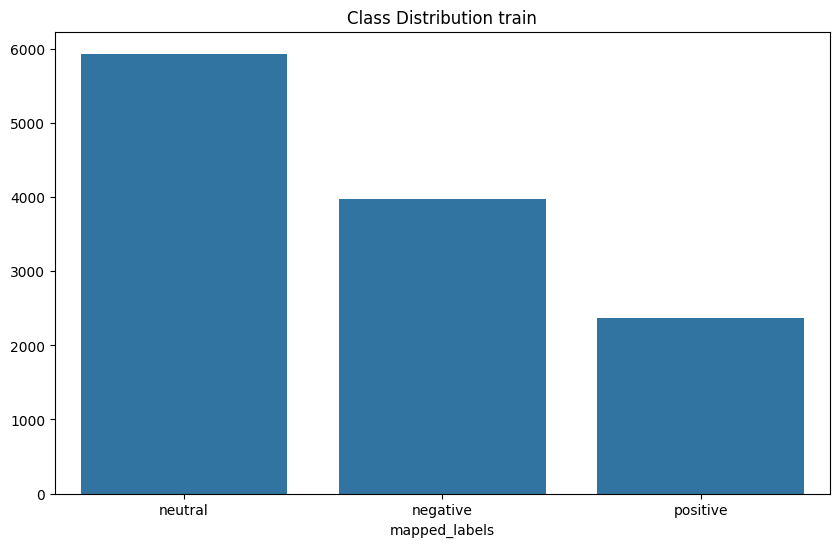

In [38]:
dist = df['mapped_labels'].value_counts()
def distribution_plot(x, y, name):
    """
    Plot a bar chart to visualize the distribution of sentiment classes.

    Args:
        x (list or pd.Index): List of sentiment class names (e.g., negative, neutral, positive).
        y (list or np.ndarray): Frequency counts corresponding to each class.
        name (str): Title of the plot.

    Returns:
        None
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(x=x, y=y)
    plt.title(name)
    plt.show()

distribution_plot(x=dist.index, y=dist.values, name='Class Distribution train')

In [39]:
def predict_sentiment_batch(df, text_column="processed_text", batch_size=32):
    """
    Perform sentiment prediction on a dataset in mini-batches using a Hugging Face pipeline.

    Args:
        df (pd.DataFrame): Input DataFrame containing text data.
        text_column (str, optional): Name of the column containing preprocessed text. Defaults to "processed_text".
        batch_size (int, optional): Number of samples per batch for prediction. Defaults to 32.

    Returns:
        list: List of predicted sentiment labels for each text (e.g., 'negative', 'neutral', 'positive').
    """
    results = []
    for i in tqdm(range(0, len(df), batch_size)):
        batch_texts = df[text_column].iloc[i:i+batch_size].tolist()
        preds = sentiment_pipeline(batch_texts)
        results.extend([p['label'] for p in preds])
    return results


In [42]:
df["roberta_pred"] = predict_sentiment_batch(df)

100%|██████████| 384/384 [25:23<00:00,  3.97s/it]


### Model Evaluation

- Generates a classification report (Precision, Recall, F1)
- Displays confusion matrix for performance visualization



📊 Report di classificazione:
              precision    recall  f1-score   support

    negative       0.68      0.71      0.70      3972
     neutral       0.68      0.73      0.70      5937
    positive       0.74      0.54      0.63      2375

    accuracy                           0.69     12284
   macro avg       0.70      0.66      0.68     12284
weighted avg       0.69      0.69      0.69     12284



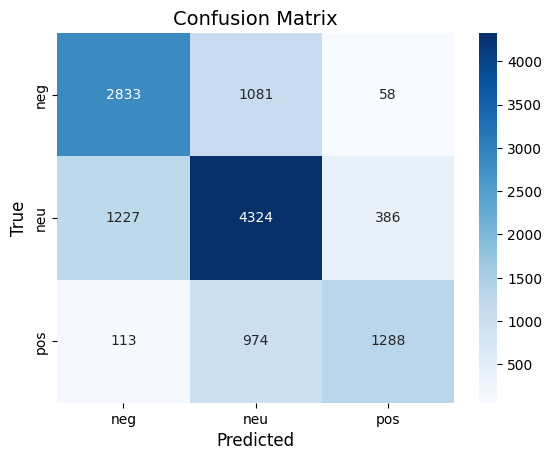

In [43]:
from sklearn.metrics import classification_report, confusion_matrix

print("\n📊 Report di classificazione:")
print(classification_report(df["mapped_labels"], df["roberta_pred"], zero_division=0))

cm = confusion_matrix(df["mapped_labels"], df["roberta_pred"], labels=["negative", "neutral", "positive"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["neg","neu","pos"], yticklabels=["neg","neu","pos"])
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.show()


### Error Analysis

Shows random examples where model predictions differ
from the true (mapped) labels to understand failure patterns.


In [44]:
errors = df[df["mapped_labels"] != df["roberta_pred"]]
print(errors.sample(5)[["processed_text", "mapped_labels", "roberta_pred"]])


                                          processed_text mapped_labels  \
214    signed agreement with bank palestine scale len...      positive   
1916   saakashvili hijacking rukh brand will leave ta...      negative   
2065   -right movement goes full nazi steve bannon pr...      negative   
11916  youre full yourself know never received threat...      negative   
320                         good watch thisisus insecure      positive   

      roberta_pred  
214        neutral  
1916       neutral  
2065       neutral  
11916      neutral  
320       negative  


### Insights Summary

- The pre-trained RoBERTa model performs reasonably well on unseen tweets.
- Most misclassifications occur between "neutral" and "positive" tweets, likely due to subtle language or sarcasm.
- The model is ready to be integrated into the MLOps pipeline (Phase 2) for CI/CD automation.
